In [2]:
import json
import math
import torch
import torch.nn as nn
import torch.optim as optim
import mido
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
def obtain_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    inputs = torch.tensor(data['notes'])
    targets = torch.tensor(data['notes_corrected'])
    return inputs, targets

RawData = obtain_data('train.json')

In [3]:
Data = obtain_data("train.json")

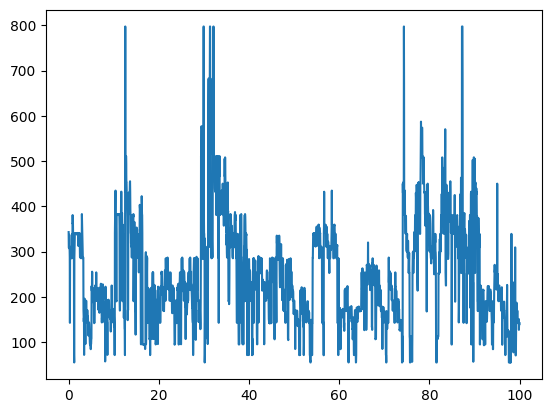

In [4]:
X = np.linspace(start=0,stop=100,num=len(Data[0]))
Y = Data[0][:][:].T[2]
plt.plot(X,Y)

In [7]:

import pretty_midi

def midi_to_pianoroll(path, fs=100, normalize=False):
    """
    Load a MIDI file and return a piano-roll numpy array and the time axis.
    - path: path to .mid file
    - fs: frames per second (time resolution)
    - normalize: if True, scale velocities to [0,1]
    Returns:
    - piano_roll: shape (T, 128), dtype float32 (T = number of time frames)
    - times: shape (T,), time in seconds for each frame
    """
    pm = pretty_midi.PrettyMIDI(path)
    pr = pm.get_piano_roll(fs=fs)  # shape (128, T), values = velocities (0-127)
    pr = pr.T.astype(np.float32)   # convert to (T, 128)
    if normalize:
        maxv = pr.max() if pr.max() > 0 else 1.0
        pr = pr / maxv
    times = np.linspace(0, pm.get_end_time(), pr.shape[0])
    return pr, times

piano_roll, times = midi_to_pianoroll('Bach_test.mid', fs=100, normalize=True)
# print((piano_roll).shape, times)

def makeThemNotes(Piece):
    NotePerDuation = []
    for piano_rolls in Piece:
        note_played = 128 # in this case we label the note 128 as no notes are being played
        for i in range(len(piano_rolls)):
            note = piano_rolls[i]
            if note > 0:
                note_played = i
        NotePerDuation.append(note_played)
    return NotePerDuation

def DataToTrain(Notes,size_of_the_window):
    # we will perform a sliding window algorithm to solve the problem
    final_data = []
    final_target_data = []
    for i in range(len(Notes) - size_of_the_window):
        window = []
        for j in range(size_of_the_window):
            window.append(Notes[i+j])
        final_data.append(window)
        if i < (len(Notes) - size_of_the_window) - 1:
            final_target_data.append(Notes[i+size_of_the_window + 1])
        else:
            final_target_data.append(Notes[len(Notes) - 1])
    return final_data,final_target_data


Notes = makeThemNotes(piano_roll)
generated_data = DataToTrain(Notes,64)
Training_data = [generated_data[0]]
Target_data = [generated_data[1]]
torch.tensor(Training_data).shape,torch.tensor(Target_data).shape

(torch.Size([1, 16836, 64]), torch.Size([1, 16836]))

In [4]:

class LSTMDataset(Dataset):
    def __init__(self, input_tensor, target_tensor):
        assert len(input_tensor) == len(target_tensor)
        self.inputs = torch.tensor(input_tensor) 
        self.targets = torch.tensor(target_tensor)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

DataSetLSTM = LSTMDataset(Training_data,Target_data)
DataLoaderLSTM = DataLoader(LSTMDataset)
